Train a RNN to Predict the value of the voltage rise on the next period


<span style='color:red'> STILL WORKING</span>

---

#### Import modules to be used

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

#### Import Module for ML

In [2]:
# import pakages forML
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, OneHotEncoder
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Import my own modules

In [3]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [4]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

In [5]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = mf.readAndReshape_input(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])

# Data cleaning on Consumption
# Replacing wrong data by the mean of surrounding periods
# 2020 -------------------------
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2
# 2022 -------------------------
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2
# Dataframe PROD HT
# Replacing missing data by the mean of surrondings periods
# Extract previous and following days 
per_index = df_prodHT.index
previous_days = df_prodHT.loc[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50'),['P0013','P0018']]
following_days = df_prodHT.loc[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50'),['P0013','P0018']]

# Put the interpolated data into the dataframe
df_prodHT.loc[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50'), ['P0013','P0018']] = (np.array(following_days) +
                                                                                                 np.array(previous_days) ) /2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('06:50','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index<'2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')


vm_mu_max, vm_mu_min = 1.0250, 0.95  # Choosen 


#### Import the voltage rise from [Voltage_rise](VoltageRiseBinary.ipynb)


In [6]:
# Import the voltage rise from 
bin_volt_rise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise.pkl')
df_final['Volt_Rise_bin'] = bin_volt_rise['Volt_Rise_Bin']

### Set variables For numerical voltage rise prediction

In [7]:
# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index<'2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                        ).between_time('07:00','18:50') ).index.to_period('10T')

In [8]:
df_final['Volt_Rise_num'] = bin_volt_rise['known']

In [9]:
# # Separate training and testing set 
df_train = df_final[df_final.index<'2020 12 31']
df_test = df_final[(df_final.index>='2020 12 31') & (df_final.index <'2021 06 01')]


# I'm using all the dataset to train the RNN to improve the performance since ive already
# tried with the testing set and get an accuraccy of 94%
# # Separate training and testing set 
# df_train = df_final[df_final.index<'2021 06 01']

# Define scaler
numerical_scaler2 = MinMaxScaler()
numerical_scaler2.fit(df_train);

train_scaled, test_scaled= map(numerical_scaler2.transform, [df_train, df_test])
# train_scaled = numerical_scaler.transform(df_train)

##### Define Timeseries  generators


In [56]:
onecHot = OneHotEncoder(sparse=False)
onecHot.fit(np.array(working_df2.index.minute).reshape((-1,1)))
onecHot.transform(np.array(working_df2.index.minute).reshape((-1,1)))

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [37]:
working_df = df_train.copy(deep=True)
working_df=working_df[working_df.index<='2020 01 02']
working_df['Minutes'] = working_df.index.minute
working_df['Day'] = working_df.index.day
working_df2 = working_df.loc[:,['Minutes', 'Day', 'P0013','P0018']]

In [39]:
preprocessor.fit(working_df2)

ColumnTransformer(transformers=[('OHE', OneHotEncoder(handle_unknown='ignore'),
                                 ['P0013', 'P0018']),
                                ('SSca', StandardScaler(), ['Day', 'Minutes'])])

In [43]:
preprocessor.transform(working_df2)

<73x64 sparse matrix of type '<class 'numpy.float64'>'
	with 219 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('OHE', categorical_preprocessor, ['P0013',	'P0018']),
    ('SSca', numerical_preprocessor, ['Day', 'Minutes'])])

In [27]:
preprocessor

ColumnTransformer(transformers=[('OHE', OneHotEncoder(handle_unknown='ignore'),
                                 ['P0013', 'P0018']),
                                ('SSca', StandardScaler(), ['Day', 'Minutes'])])

In [18]:
gen_length = 70 # 1 hour

# batchSize = (gen_length//6)*24*7; #  (gen_length//6)  To convert in hour *24 hour * 7 days
batchSize = 30; #  (gen_length//6)  To convert in hour *24 hour * 7 days

train_generator = TimeseriesGenerator(train_scaled, train_scaled[:,4:], 
                                      length = gen_length, 
                                      batch_size= batchSize )

test_genarator = TimeseriesGenerator(test_scaled, test_scaled[:,4:], 
                                     length = gen_length, 
                                     batch_size= batchSize)

# n_features = train_generator[0][0][0].shape[1]  # Define total number of features
n_features_inputs = 6  # Define total number of features
n_features_outputs = 2  # Define total number of features

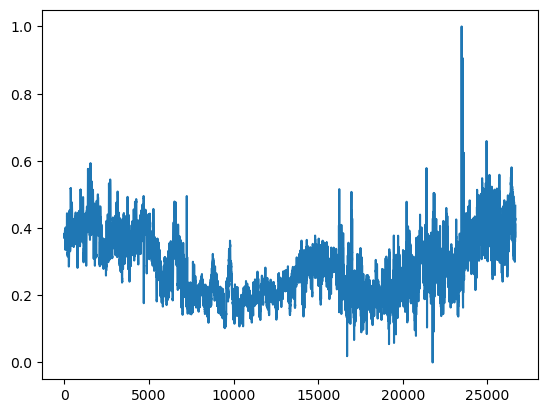

In [19]:
plt.plot(train_scaled[:,0])

#### Define RNN

In [20]:
num_vRise_RNN = Sequential()

num_vRise_RNN.add( LSTM(units=256, activation='relu', input_shape=(gen_length,n_features_inputs),) )
num_vRise_RNN.add(Dropout(0.5))
# num_vRise_RNN.add( LSTM(units=256, activation='relu', input_shape=(gen_length,n_features)) )
num_vRise_RNN.add(Dense(units=n_features_outputs, activation='relu'))

num_vRise_RNN.compile(optimizer='adam', loss='mse', metrics=['accuracy'], )

##### Define early stopping mechanism

In [21]:
early_stop = EarlyStopping(monitor= 'val_loss',patience=5, mode='min')

#### Train RNN

In [22]:
num_vRise_RNN.fit(train_generator, 
                  epochs=10, 
                  callbacks=[early_stop], 
                  validation_data=test_genarator)

Epoch 1/10
886/886 [==============================] - 125s 141ms/step - loss: 0.0099 - accuracy: 0.7086 - val_loss: 0.0056 - val_accuracy: 0.8630
Epoch 2/10
886/886 [==============================] - 124s 140ms/step - loss: 0.0067 - accuracy: 0.7823 - val_loss: 0.0050 - val_accuracy: 0.8771
Epoch 3/10
886/886 [==============================] - 127s 144ms/step - loss: 0.0061 - accuracy: 0.8081 - val_loss: 0.0048 - val_accuracy: 0.8779
Epoch 4/10
886/886 [==============================] - 137s 155ms/step - loss: 0.0058 - accuracy: 0.8210 - val_loss: 0.0050 - val_accuracy: 0.8726
Epoch 5/10
886/886 [==============================] - 129s 146ms/step - loss: 0.0057 - accuracy: 0.8179 - val_loss: 0.0048 - val_accuracy: 0.8653
Epoch 6/10
886/886 [==============================] - 123s 139ms/step - loss: 0.0056 - accuracy: 0.8199 - val_loss: 0.0046 - val_accuracy: 0.8778
Epoch 7/10
886/886 [==============================] - 125s 142ms/step - loss: 0.0054 - accuracy: 0.8271 - val_loss: 0.0047 -

<AxesSubplot:>

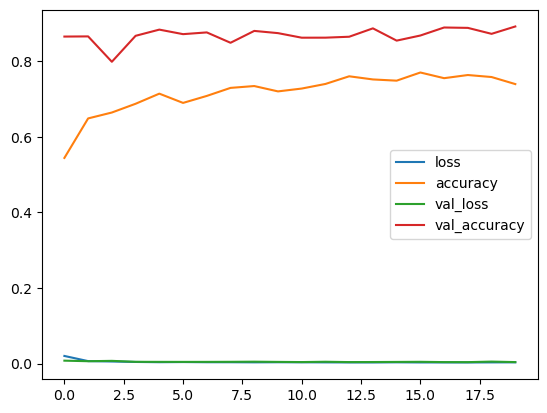

In [102]:
pd.DataFrame(num_vRise_RNN.history.history).plot()

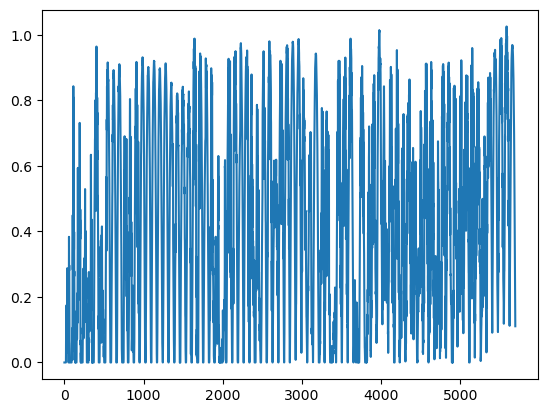

In [33]:
plt.plot(test_scaled[:,-1])